In [1]:
#### Reference paper https://arxiv.org/abs/1808.08219

#### Keeping tau_i fixed and then calculating y_i as per the value of 
#### tau_i.


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


# Reference paper https://arxiv.org/abs/1808.08219
# Referencing from Eq.(3.2) to Eq.(3.7) in https://arxiv.org/abs/1808.08219
# Only using the dimensionless equations
# Using PBH as the sole source og Gravitational potential
# Explicitly adding Hubble expansion (or deceleration term) in RD with H(t)=1/2t
# so that v_i = H r_i .
# Using either solve_ivp or adaptive integrator as the differential equation solver


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * r**3) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return (y_ta**4) - (8 * y_ta * (tau**2)) + ((2 * gamma - gamma**2) * (tau**2))
    r_ta_initial = (8 * (tau**2))**(1/3) 
    return fsolve(expression, r_ta_initial, xtol=1e-10)[0]


# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)


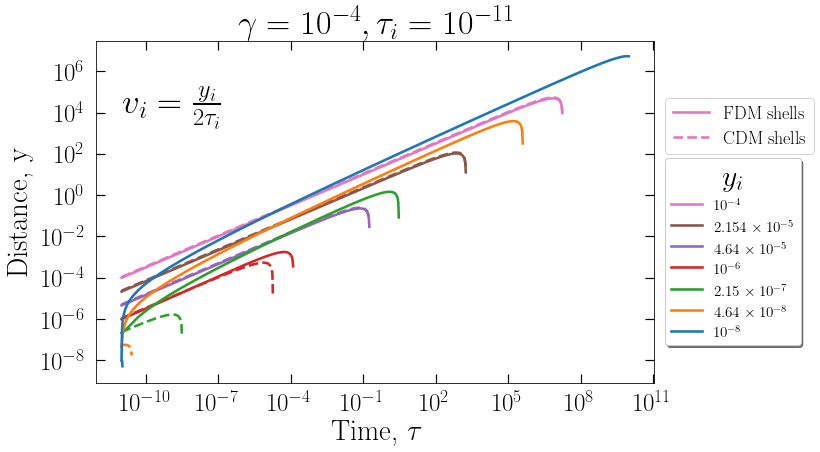

In [2]:
fig, ax = plt.subplots(1, figsize=(10, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




gamma = 1e-4
tau_f = 1e10
yi_arr = np.geomspace(1e-4, 1e-8, 7)


colors = ['C6','C5','C4', 'C3', 'C2', 'C1', 'C0'] 
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-11      
    v_i =  (y_i/(2 * tau_i))
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 1000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0, t_eval=tau_arr,  args=(gamma,), method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    sol_cdm = solve_ivp(j_cdm, [tau_i, tau_f], y0, t_eval=tau_arr,   method='RK45',
        rtol=1e-6, atol=1e-8,  events=[event_y_max, event_y_min])

    #print("y_i =", y_i, "; y_FDM =", sol_fdm.y[0]), 
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color = color)
    ax.loglog(sol_cdm.t, sol_cdm.y[0]*1.1,  color = color, ls ='--')

    
 
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["FDM shells", "CDM shells"], title = "",
        title_fontsize = 33, loc = (1.02, 0.67), prop = {"size":18})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], [  
              r'$10^{-4}$', r'$ 2.154\times10^{-5}$', r'$4.64\times10^{-5}$', r'$10^{-6}$',r'$2.15\times10^{-7}$',
                r'$4.64\times10^{-8}$',  r'$10^{-8}$'                                                  
              ],prop = {'size':15.2},
              loc = (1.02, 0.11),shadow = True, title = '$y_{i}$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 25)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.text(1e-11, 1e4, r'$v_i = \frac{y_i} {2 \tau_i}$', fontsize = 35)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=29)
plt.ylabel('Distance, y', fontsize=29, labelpad=9)
plt.title(r'$\gamma = 10^{-4}, \tau_i = 10^{-11}$', fontsize = 34)
plt.savefig('Diff_shells_vi.pdf', bbox_inches = 'tight')
plt.show()

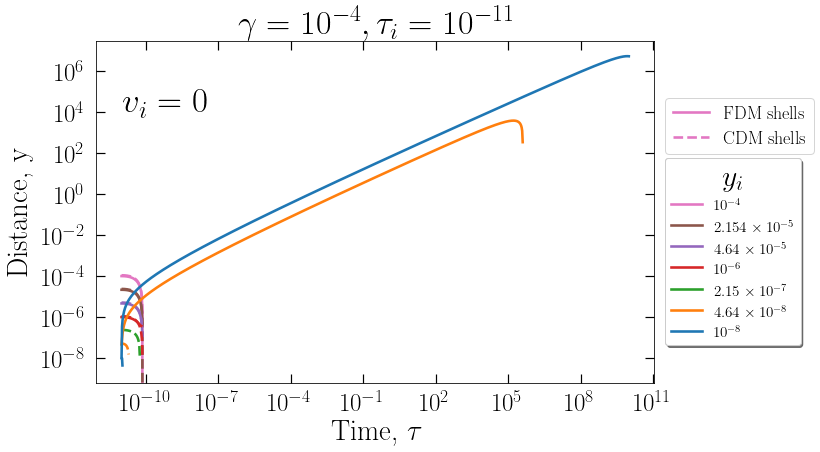

In [3]:
fig, ax = plt.subplots(1, figsize=(10, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')




gamma = 1e-4
tau_f = 1e10
yi_arr = np.geomspace(1e-4, 1e-8, 7)


colors = ['C6','C5','C4', 'C3', 'C2', 'C1', 'C0'] 
for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-11      
    v_i =  1e-15 if y_i < 1e-7 else 0 # (y_i/(2 * tau_i))
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 1000) 

    
    sol_fdm = solve_ivp(j_fdm, [tau_i, tau_f], y0,  args=(gamma,), t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

    sol_cdm = solve_ivp(j_cdm, [tau_i, tau_f], y0, t_eval=tau_arr, method='RK45',
        rtol=1e-6, atol=1e-8,  events=[event_y_max, event_y_min])

    #print("y_i =", y_i, "; y_FDM =", sol_fdm.y[0]), 
    ax.loglog(sol_fdm.t, sol_fdm.y[0], color = color)
    ax.loglog(sol_cdm.t, sol_cdm.y[0]*1.1,  color = color, ls ='--')

    
 
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["FDM shells", "CDM shells"], title = "",
        title_fontsize = 33, loc = (1.02, 0.67), prop = {"size":18})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], [  
              r'$10^{-4}$', r'$ 2.154\times10^{-5}$', r'$4.64\times10^{-5}$', r'$10^{-6}$',r'$2.15\times10^{-7}$',
                r'$4.64\times10^{-8}$',  r'$10^{-8}$'                                                  
              ],prop = {'size':15.2},
              loc = (1.02, 0.11),shadow = True, title = '$y_{i}$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 25)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.text(1e-11, 1e4, r'$v_i = 0$', fontsize = 35)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=29)
plt.ylabel('Distance, y', fontsize=29, labelpad=9)
plt.title(r'$\gamma = 10^{-4}, \tau_i = 10^{-11}$', fontsize = 34)
plt.savefig('Diff_shells_vi0.pdf', bbox_inches = 'tight')
plt.show()

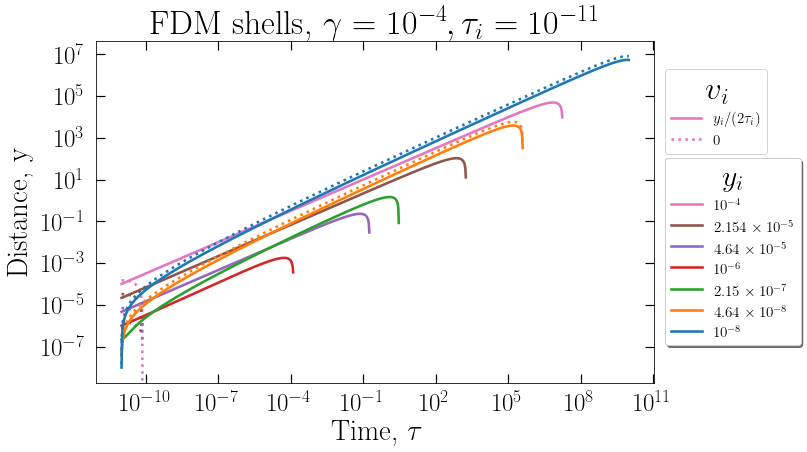

In [4]:
fig, ax = plt.subplots(1, figsize=(10, 6.3))
plt.rc('lines', linewidth=2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



gamma = 1e-4
tau_f = 1e10
yi_arr = np.geomspace(1e-4, 1e-8, 7)
tau_arr = np.geomspace(1e-11, tau_f, 1000)  
colors = ['C6','C5','C4', 'C3', 'C2', 'C1', 'C0'] 

for i, (y_i, color) in enumerate(zip(yi_arr, colors)):
    tau_i = 1e-11  
    v_i_1 = y_i / (2 * tau_i)
    y0_1 = [y_i, v_i_1]

    sol_fdm_1 = solve_ivp(j_fdm, [tau_i, tau_f], y0_1,  args=(gamma,), t_eval=tau_arr, method='RK45',
                           rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])
    sol_cdm_1 = solve_ivp(j_cdm, [tau_i, tau_f], y0_1, t_eval=tau_arr, method='RK45',
                           rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])

   
    v_i_2 = 1e-15 if y_i < 1e-7 else 0 #0
    y0_2 = [y_i, v_i_2]

    sol_fdm_2 = solve_ivp(j_fdm, [tau_i, tau_f], y0_2,  args=(gamma,), t_eval=tau_arr, method='RK45',
                           rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])
    sol_cdm_2 = solve_ivp(j_cdm, [tau_i, tau_f], y0_2, t_eval=tau_arr, method='RK45',
                           rtol=1e-6, atol=1e-8, events=[event_y_max, event_y_min])
    
    
    ax.loglog(sol_fdm_1.t, sol_fdm_1.y[0], color=color, label=f'$y_i={y_i:.1e}$ (v_i = y_i/2t_i)')
    ax.loglog(sol_fdm_2.t, sol_fdm_2.y[0]*1.5, color=color, ls=':', label=f'$y_i={y_i:.1e}$ (v_i = 0)')

ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$y_i/(2\tau_i)$", "$ 0$"], title = r"$v_{i}$",
        title_fontsize = 33, loc = (1.02, 0.67), prop = {"size":15})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], [  
              r'$10^{-4}$', r'$ 2.154\times10^{-5}$', r'$4.64\times10^{-5}$', r'$10^{-6}$',r'$2.15\times10^{-7}$',
                r'$4.64\times10^{-8}$',  r'$10^{-8}$'                                                  
              ],prop = {'size':15.2},
              loc = (1.02, 0.11),shadow = True, title = '$y_{i}$' ,title_fontsize = 30,
           facecolor = 'white',fontsize = 25)
    
ax.add_artist(legend1)
ax.add_artist(legend2)

#plt.text(1e-11, 1e5, r'$\tau_i = 10^{-11}$', fontsize = 30)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(r'Time, $\tau$', fontsize=29)
plt.ylabel('Distance, y', fontsize=29, labelpad=9)
plt.title(r'FDM shells, $\gamma = 10^{-4}, \tau_i = 10^{-11}$', fontsize = 34)
plt.savefig('Diff_shells_vicomb.pdf', bbox_inches = 'tight')
plt.show()

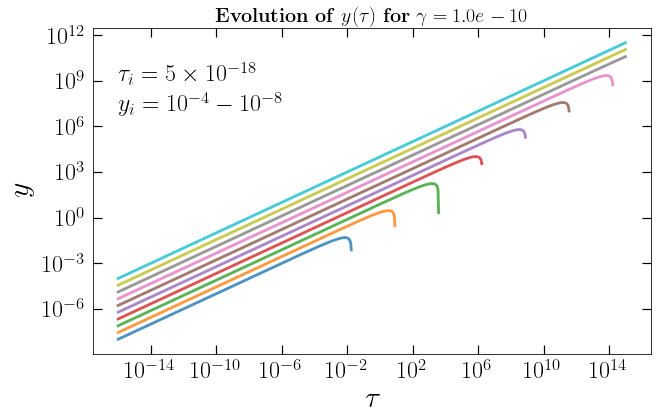

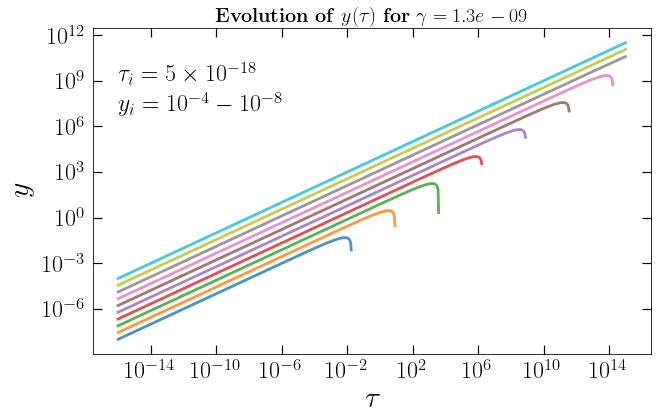

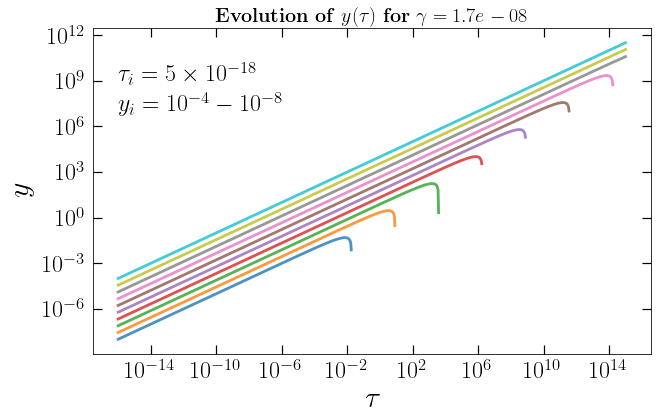

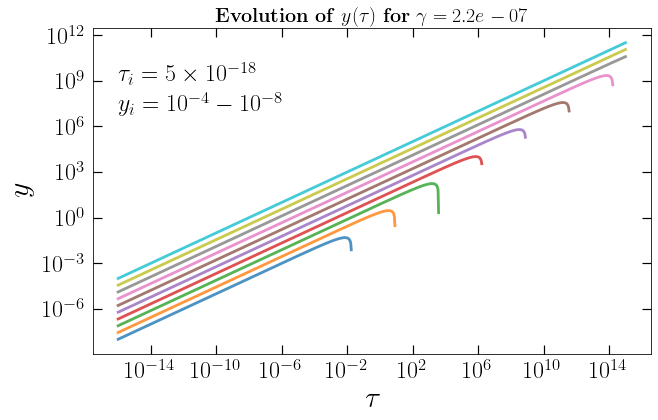

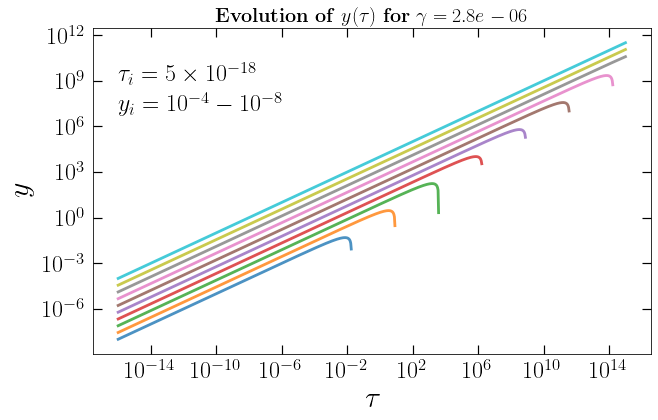

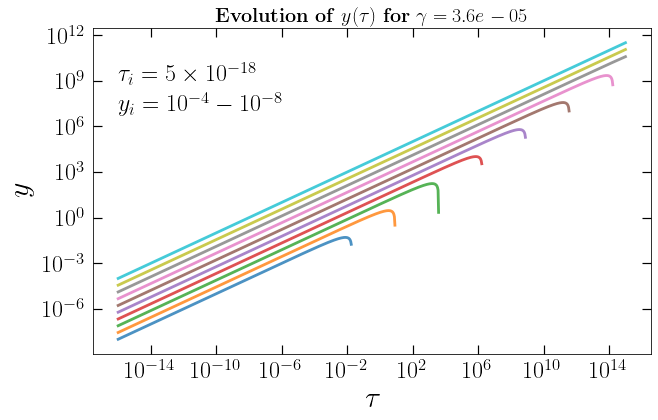

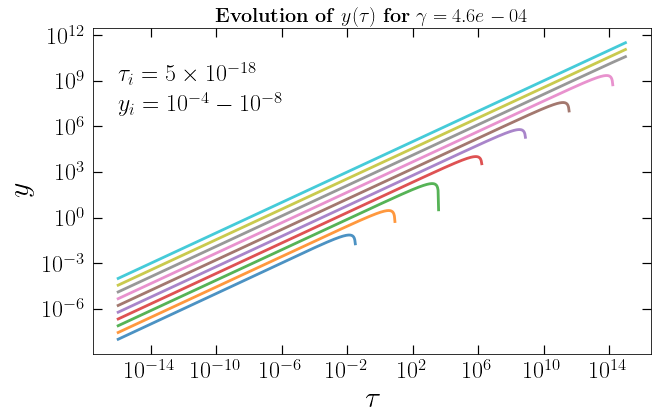

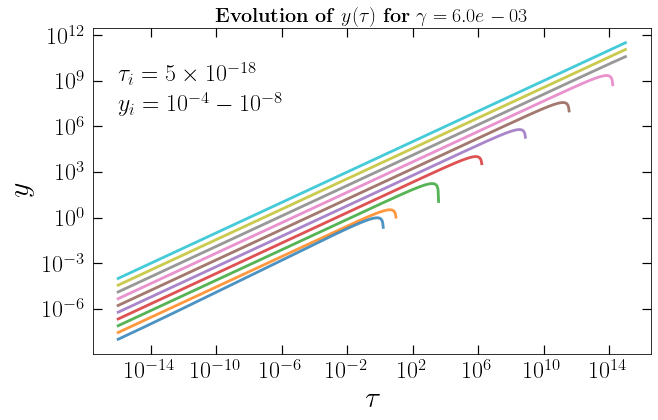

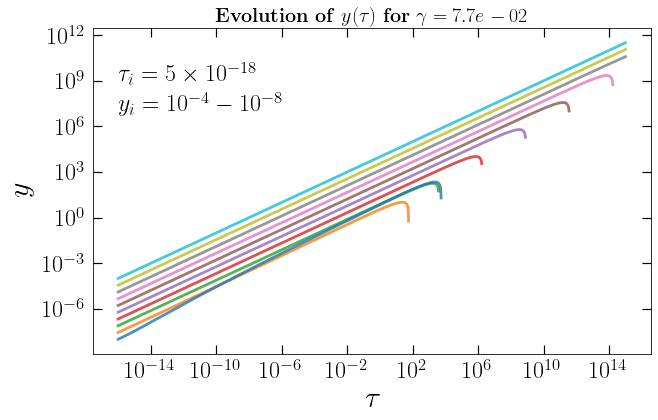

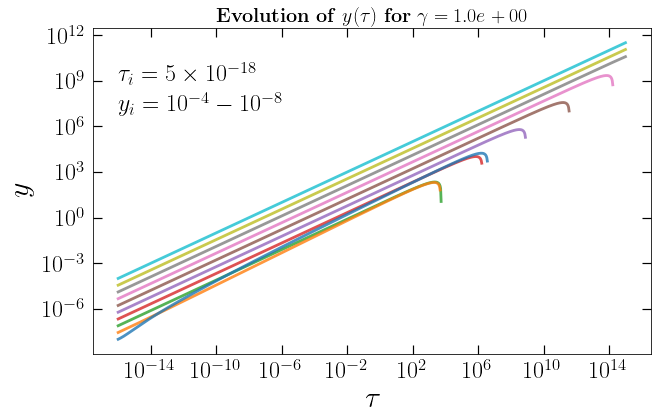

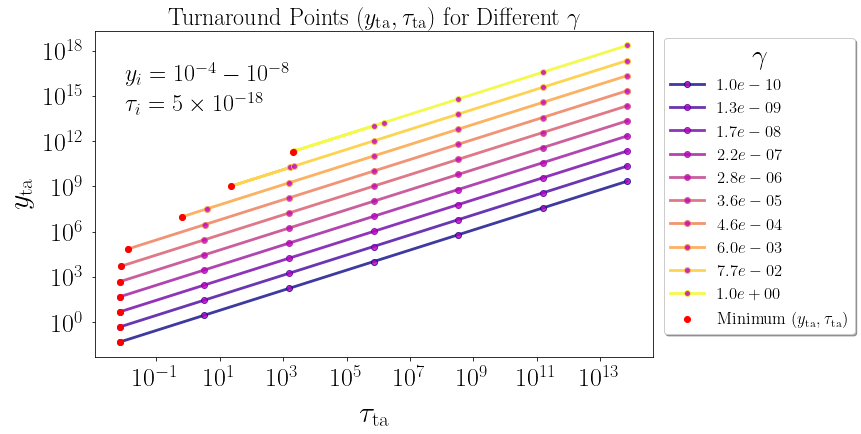

Gamma: 1.0e-10, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 1.3e-09, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 1.7e-08, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 2.2e-07, Tau_ta: 7.174e-03, Y_ta: 4.820e-02, Y_i: 1.0e-08
Gamma: 2.8e-06, Tau_ta: 7.199e-03, Y_ta: 4.831e-02, Y_i: 1.0e-08
Gamma: 3.6e-05, Tau_ta: 7.535e-03, Y_ta: 4.978e-02, Y_i: 1.0e-08
Gamma: 4.6e-04, Tau_ta: 1.304e-02, Y_ta: 7.142e-02, Y_i: 1.0e-08
Gamma: 6.0e-03, Tau_ta: 6.647e-01, Y_ta: 9.708e-01, Y_i: 1.0e-08
Gamma: 7.7e-02, Tau_ta: 2.284e+01, Y_ta: 1.033e+01, Y_i: 2.8e-08
Gamma: 1.0e+00, Tau_ta: 2.030e+03, Y_ta: 2.047e+02, Y_i: 2.8e-08


In [5]:
gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-8, 10)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  
tau_arr = np.geomspace(tau_i, tau_f, 1000)  


def y(gamma, tau_arr):
    solutions = []
    turnaround_points = []
    for idx, y_i in enumerate(yi_values):
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))  
        if sol.t_events[0].size > 0:
            turnaround_points.append((sol.t_events[0][0], sol.y_events[0][0][0], y_i))  
    return solutions, turnaround_points


gamma_results = {gamma: y(gamma, tau_arr) for gamma in gamma_values}
min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      for gamma in gamma_values]
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i

for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 5\times10^{-18}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"y1_evolution1_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)
    
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(0.01, 1e16, '$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
plt.text(0.01, 1e14, r'$\tau_i = 5\times10^{-18}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("turnaround_points.pdf", bbox_inches='tight')
plt.show()









for gamma, min_tau, min_y, min_yi in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Tau_ta: {min_tau:.3e}, Y_ta: {min_y:.3e}, Y_i: {min_yi:.1e}")

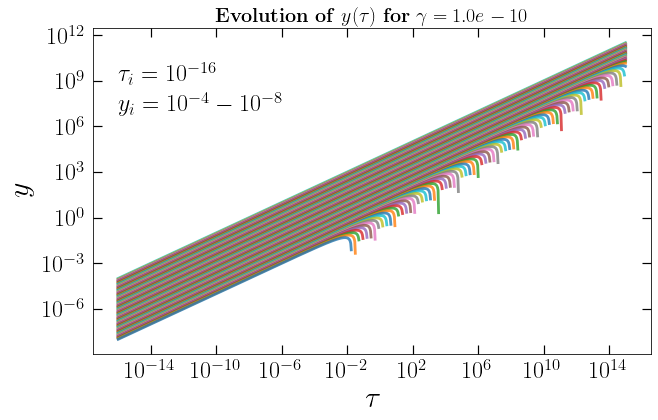

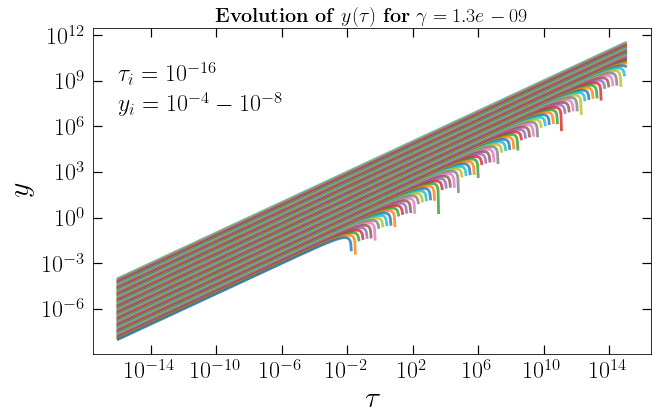

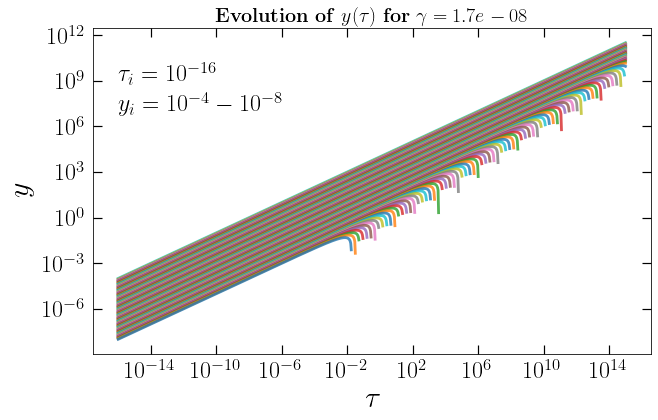

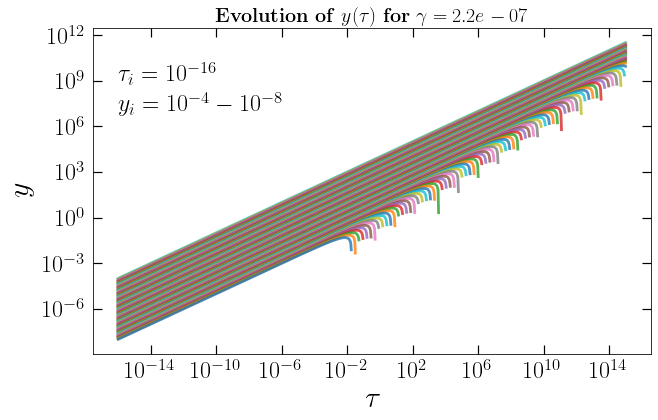

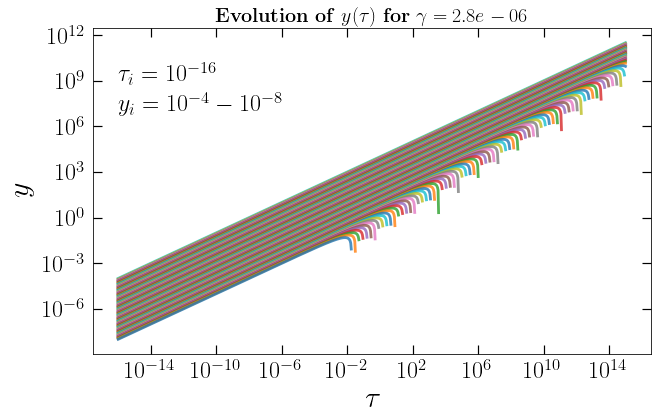

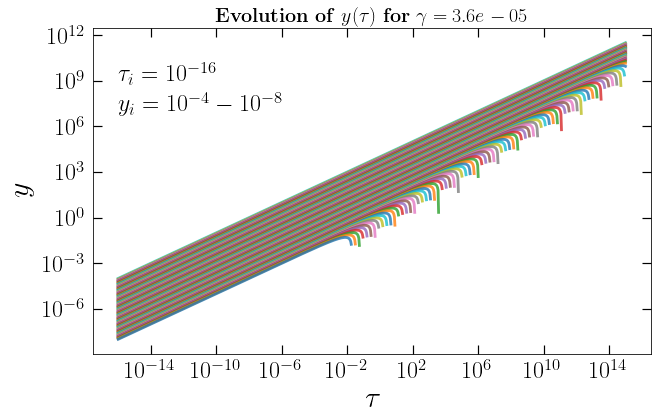

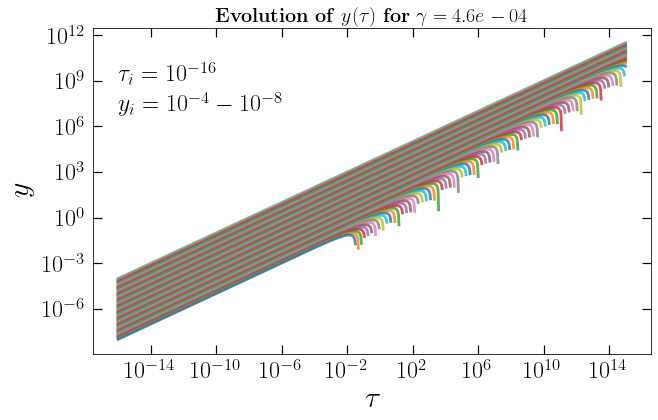

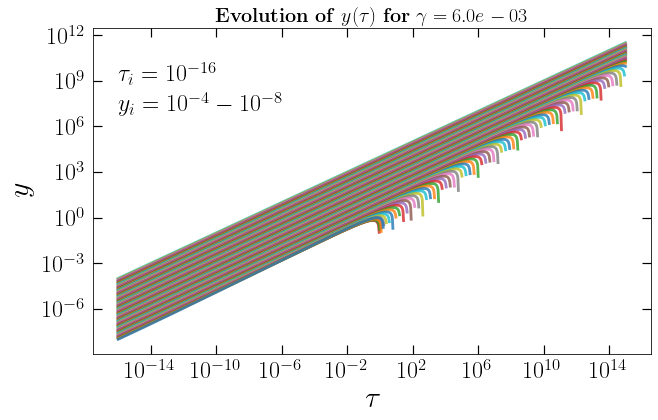

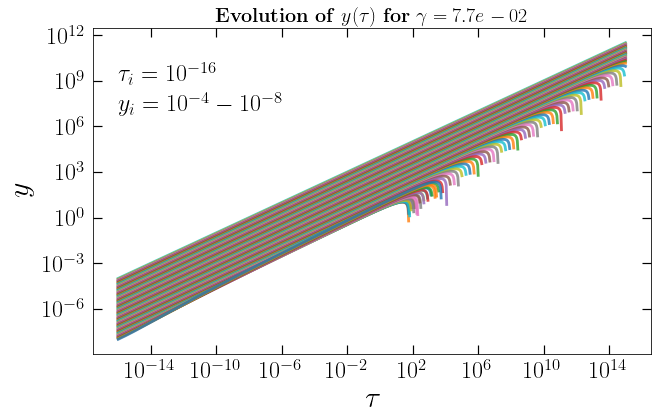

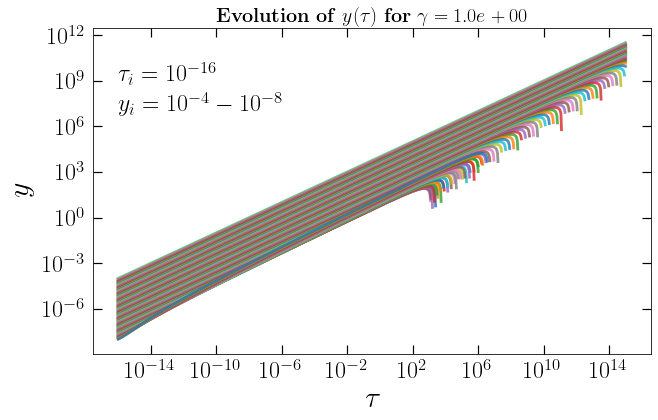

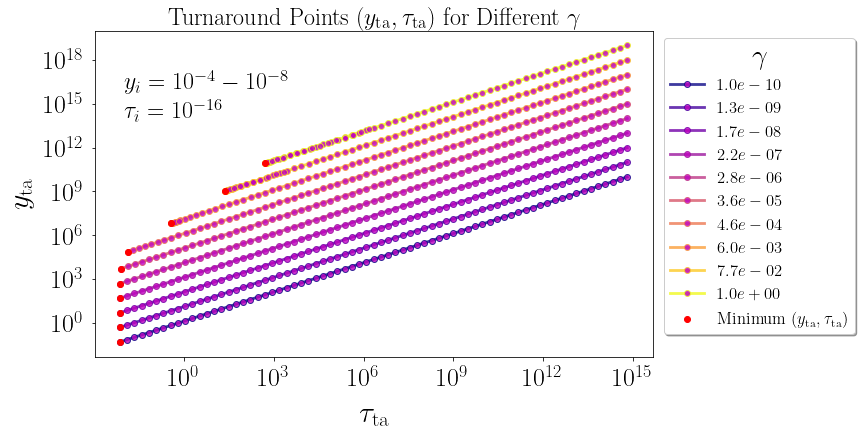

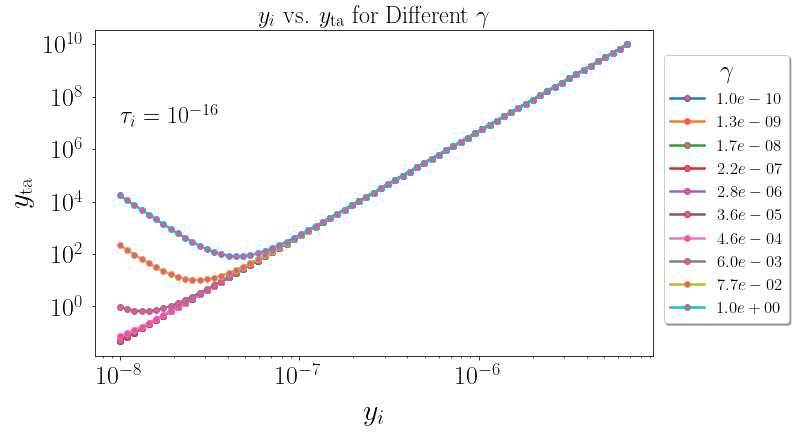

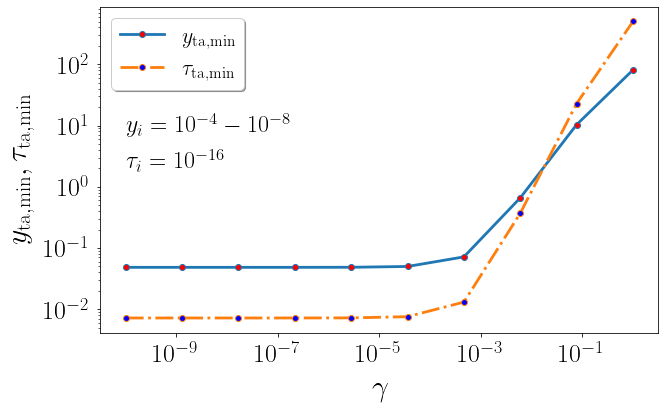

Gamma: 1.0e-10, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 1.3e-09, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 1.7e-08, Tau_ta: 7.172e-03, Y_ta: 4.819e-02, Y_i: 1.0e-08
Gamma: 2.2e-07, Tau_ta: 7.174e-03, Y_ta: 4.820e-02, Y_i: 1.0e-08
Gamma: 2.8e-06, Tau_ta: 7.199e-03, Y_ta: 4.831e-02, Y_i: 1.0e-08
Gamma: 3.6e-05, Tau_ta: 7.535e-03, Y_ta: 4.978e-02, Y_i: 1.0e-08
Gamma: 4.6e-04, Tau_ta: 1.304e-02, Y_ta: 7.142e-02, Y_i: 1.0e-08
Gamma: 6.0e-03, Tau_ta: 3.683e-01, Y_ta: 6.576e-01, Y_i: 1.3e-08
Gamma: 7.7e-02, Tau_ta: 2.284e+01, Y_ta: 1.033e+01, Y_i: 2.8e-08
Gamma: 1.0e+00, Tau_ta: 5.007e+02, Y_ta: 8.089e+01, Y_i: 4.4e-08


In [6]:
gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-8, 100)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  
tau_arr = np.geomspace(tau_i, tau_f, 1000)  


def y(gamma, tau_arr):
    solutions = []
    turnaround_points = []
    for idx, y_i in enumerate(yi_values):
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))  
        if sol.t_events[0].size > 0:
            turnaround_points.append((sol.t_events[0][0], sol.y_events[0][0][0], y_i))  
    return solutions, turnaround_points


gamma_results = {gamma: y(gamma, tau_arr) for gamma in gamma_values}
min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      for gamma in gamma_values]
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i

for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"y1_evolution1_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)
    
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(0.01, 1e16, '$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
plt.text(0.01, 1e14, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("turnaround_points1.pdf", bbox_inches='tight')
plt.show()

#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, points)) in enumerate(gamma_results.items()):
    _, y_ta, yi_ta = zip(*points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta.pdf", bbox_inches='tight')
plt.show()



# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
ax4.loglog(gamma_arr, min_y_arr, marker='o', markersize=6, markerfacecolor='r',ls = '-')
ax4.loglog(gamma_arr, min_tau_arr,  marker='o', markersize=6, markerfacecolor='b', ls = '-.')

plt.text(1e-10, 8, '$y_i = 10^{-4} - 10^{-8}$', fontsize=24)
plt.text(1e-10, 2, r'$\tau_i = 10^{-16}$', fontsize=24)


ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("yta_min_vs_gamma.pdf", bbox_inches='tight')
plt.show()


for gamma, min_tau, min_y, min_yi in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Tau_ta: {min_tau:.3e}, Y_ta: {min_y:.3e}, Y_i: {min_yi:.1e}")

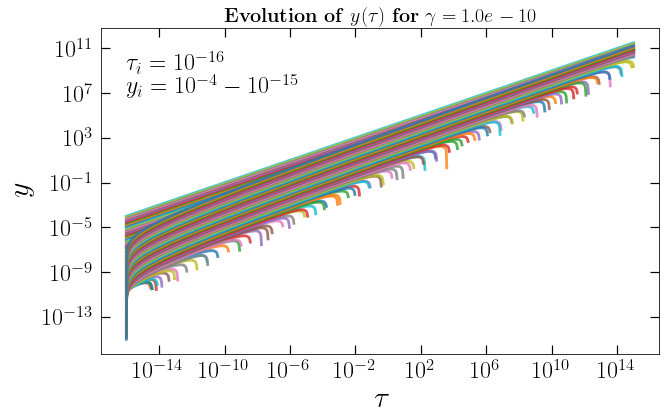

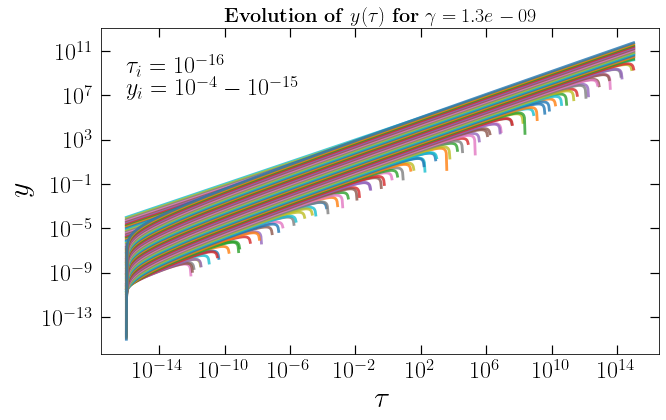

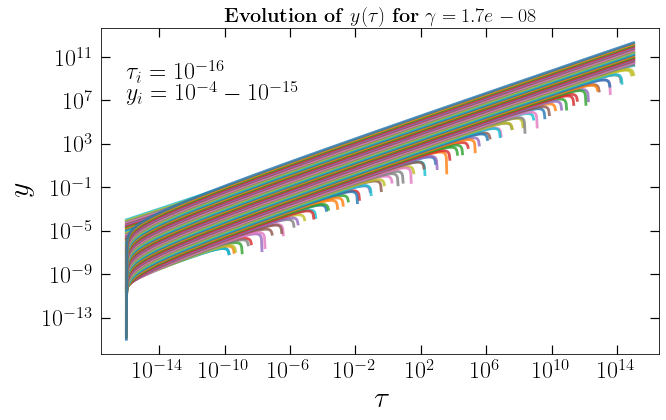

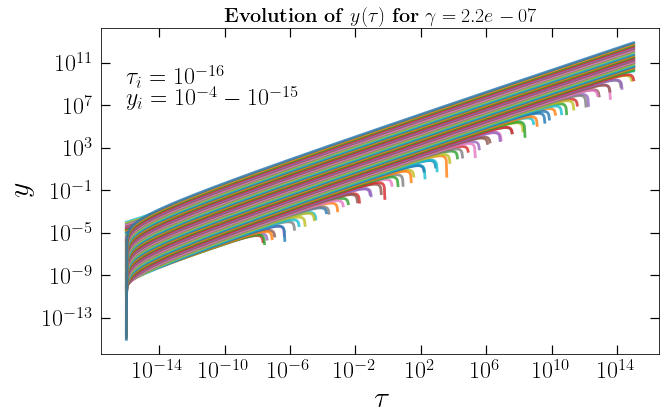

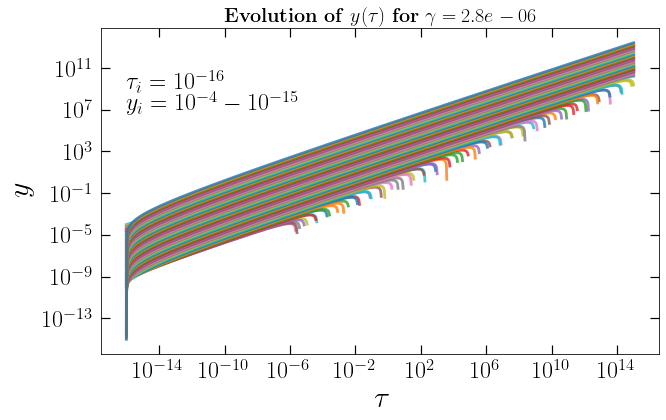

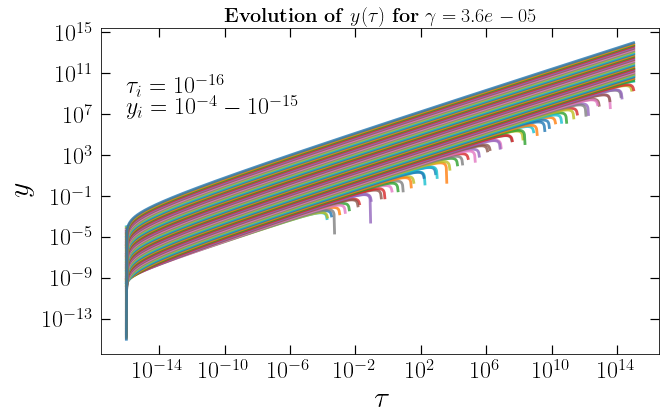

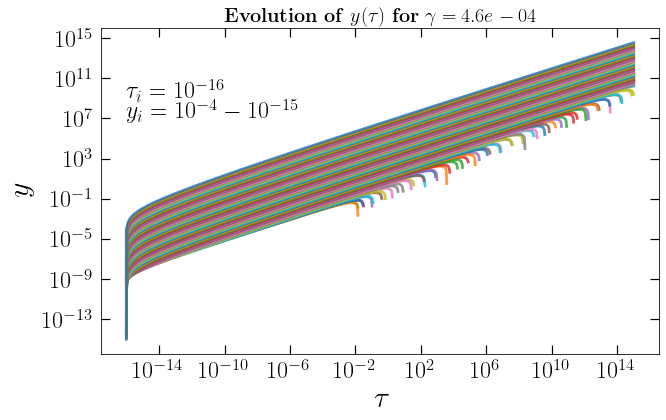

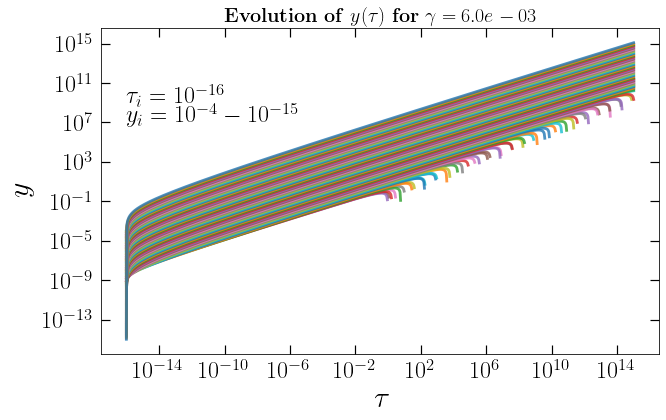

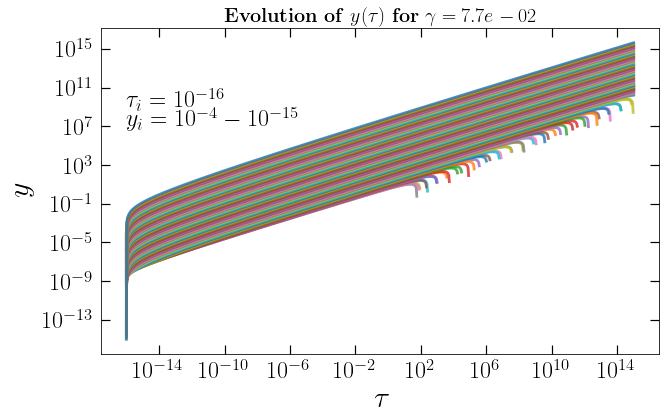

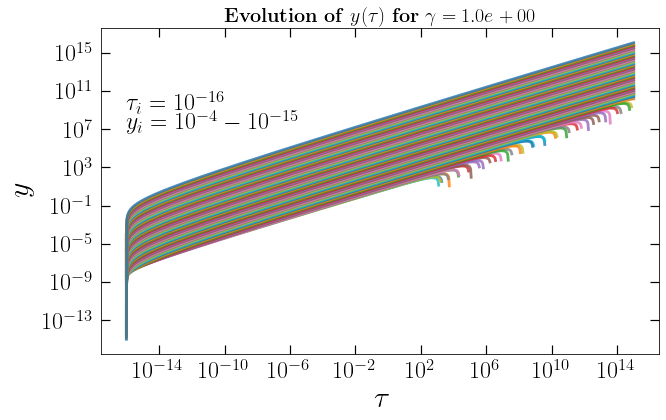

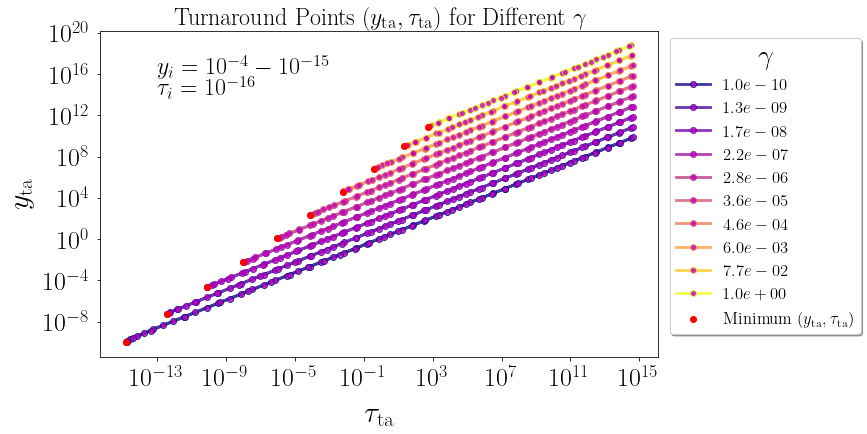

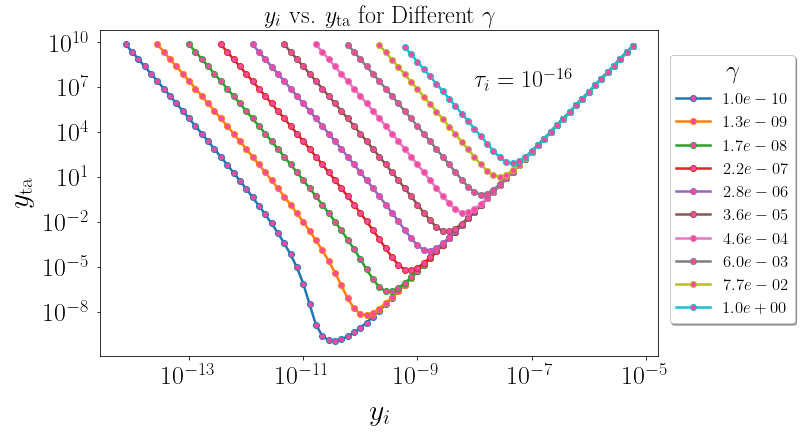

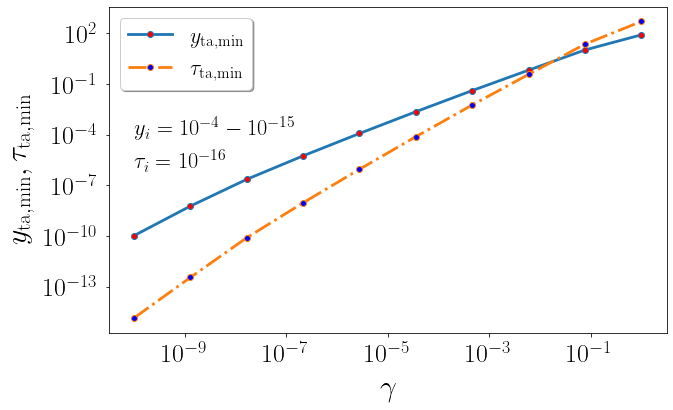

Gamma: 1.0e-10, Tau_ta: 1.457e-15, Y_ta: 1.078e-10, Y_i: 3.6e-11
Gamma: 1.3e-09, Tau_ta: 3.651e-13, Y_ta: 6.033e-09, Y_i: 1.3e-10
Gamma: 1.7e-08, Tau_ta: 8.107e-11, Y_ta: 2.308e-07, Y_i: 2.8e-10
Gamma: 2.2e-07, Tau_ta: 9.465e-09, Y_ta: 5.651e-06, Y_i: 7.7e-10
Gamma: 2.8e-06, Tau_ta: 9.067e-07, Y_ta: 1.191e-04, Y_i: 1.7e-09
Gamma: 3.6e-05, Tau_ta: 7.661e-05, Y_ta: 2.305e-03, Y_i: 3.6e-09
Gamma: 4.6e-04, Tau_ta: 5.762e-03, Y_ta: 4.098e-02, Y_i: 6.0e-09
Gamma: 6.0e-03, Tau_ta: 3.725e-01, Y_ta: 6.622e-01, Y_i: 1.3e-08
Gamma: 7.7e-02, Tau_ta: 2.284e+01, Y_ta: 1.033e+01, Y_i: 2.8e-08
Gamma: 1.0e+00, Tau_ta: 5.013e+02, Y_ta: 8.102e+01, Y_i: 4.6e-08


In [8]:
# Keeping tau_i fixed as 1e-16, try increasing the range of 
# y_i-values by going to lower values of y_i
# Then check how the shape of the y_ta,min ; tau_ta,min vs gamma plot changes.


gamma_values = np.geomspace(1e-10, 1, 10) 
yi_values = np.geomspace(1e-4, 1e-15, 100)  
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  
tau_arr = np.geomspace(tau_i, tau_f, 1000)  


def y(gamma, tau_arr):
    solutions = []
    turnaround_points = []
    for idx, y_i in enumerate(yi_values):
        v_i = y_i / (2 * tau_i)
        y0 = [y_i, v_i]
        sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                        method='RK45', t_eval=tau_arr, 
                        rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
        solutions.append((sol.t, sol.y[0], y_i))  
        if sol.t_events[0].size > 0:
            turnaround_points.append((sol.t_events[0][0], sol.y_events[0][0][0], y_i))  
    return solutions, turnaround_points


gamma_results = {gamma: y(gamma, tau_arr) for gamma in gamma_values}
min_turnaround_pts = [(gamma, *min(gamma_results[gamma][1], key=lambda x: x[1])) 
                      for gamma in gamma_values]
gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))  



#plotting y vs tau for different values of gamma, each with different values of y_i

for i, (gamma, (solutions, _)) in enumerate(gamma_results.items()):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    plt.rc('lines', linewidth = 2.8)
    plt.rcParams['font.family'] = 'serif'
    plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

    for j, ((tau_vals, y_vals, y_i), color) in enumerate(zip(solutions, colors * (len(solutions) // len(colors) + 1))):
        ax1.loglog(tau_vals, y_vals, color=color, alpha=0.8, label=f"${y_i:.1e}$")
    
    plt.text(tau_i, 1e9, r'$\tau_i = 10^{-16}$', fontsize=24)
    plt.text(tau_i, 1e7, r'$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
    ax1.tick_params(axis='x', pad=6.9)
    ax1.tick_params(axis='y', pad=6.9)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel(r'$\tau$', fontsize=30)
    plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    plt.savefig(f"y1_evolution1_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    plt.show()



    
    
#plotting (y_ta, tau_ta) points for different values of gamma (each with different values of y_i)
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, points)) in enumerate(gamma_results.items()): 
    tau_ta, y_ta, yi_ta = zip(*points)  
    y_ta_scaled = [y * 10**i for y in y_ta] 
    ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], label=f"${gamma:.1e}$", marker='o', markersize=6, markerfacecolor='m', alpha=0.8)
    
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
min_y_arr_scaled = [y * 10**i for i, y in enumerate(min_y_arr)]
ax2.scatter(min_tau_arr, min_y_arr_scaled, color='r', zorder=10, label="Minimum $( y_\\mathrm{ta}, \\tau_\\mathrm{ta})$")

plt.text(1e-13, 1e16, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-13, 1e14, r'$\tau_i = 10^{-16}$', fontsize=24)
ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=24)
ax2.legend(prop={'size':16.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=28,
           facecolor='white', fontsize=12)
plt.savefig("turnaround_points1.pdf", bbox_inches='tight')
plt.show()

#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, (gamma, (_, points)) in enumerate(gamma_results.items()):
    _, y_ta, yi_ta = zip(*points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=6, markerfacecolor='#fd49a0', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")

    
#plt.text(1e-8, 1e9, '$y_i = 10^{-4} - 10^{-15}$', fontsize=24)
plt.text(1e-8, 1e7, r'$\tau_i = 10^{-16}$', fontsize=24)
ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax3.set_xlabel(r'$y_i$', fontsize=30, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=30, labelpad=10)
ax3.set_title(r'$y_i$ vs. $y_\mathrm{ta}$ for Different $\gamma$', fontsize=24)
ax3.legend(prop={'size':16.7}, loc=(1.02, 0.1), shadow=True, title=r'$\gamma$', title_fontsize=25,
           facecolor='white', fontsize=12)
plt.savefig("yi_vs_yta.pdf", bbox_inches='tight')
plt.show()



# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
ax4.loglog(gamma_arr, min_y_arr, marker='o', markersize=6, markerfacecolor='r',ls = '-')
ax4.loglog(gamma_arr, min_tau_arr,  marker='o', markersize=6, markerfacecolor='b', ls = '-.')

plt.text(1e-10, 1e-4, '$y_i = 10^{-4} - 10^{-15}$', fontsize=22.5)
plt.text(1e-10, 1e-6, r'$\tau_i = 10^{-16}$', fontsize=22.5)


ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min}$"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("yta_min_vs_gamma.pdf", bbox_inches='tight')
plt.show()


for gamma, min_tau, min_y, min_yi in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Tau_ta: {min_tau:.3e}, Y_ta: {min_y:.3e}, Y_i: {min_yi:.1e}")

Slope and intercept of fitting function = [1.18186002 5.48386504]


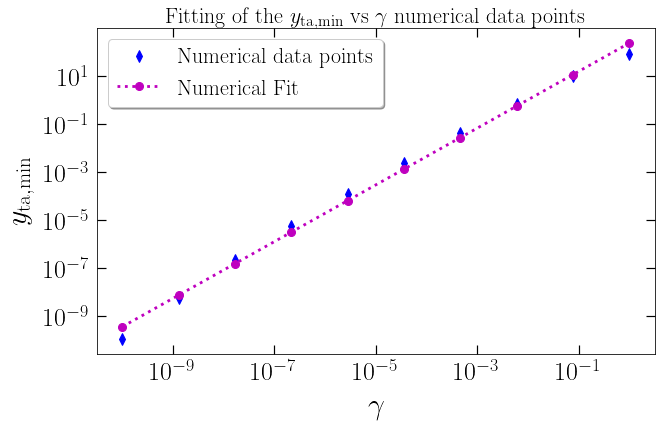

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
x  = gamma_arr
y  = min_y_arr

plt.loglog(x, y, 'bd',  label = 'data', markersize = 8)

p = np.polyfit(np.log(x), np.log(y), 1)  # F(x) = (x**m)(10**b) with m = slope, b = intercept.
z = np.polyval(p, np.log(x))
plt.loglog(x, np.exp(z), 'mo', ls = ':', label = 'fit', markersize = 8)
print("Slope and intercept of fitting function =", p) 
ax.tick_params(axis='x', pad=6.9)
ax.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax.set_ylabel(r'$ y_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax.legend(["Numerical data points", "Numerical Fit"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r'Fitting of the $y_\mathrm{ta, min}$ vs $\gamma$ numerical data points', fontsize = 22 )
plt.savefig("yta_min_vs_gamma.pdf", bbox_inches='tight')
plt.show()


# So, the fitting function is y_ta_min(gamma) = (10**(5.4838/np.log(10)))  * (gamma**1.1818)  

Slope and intercept of fitting function = [1.75633466 7.75041435]


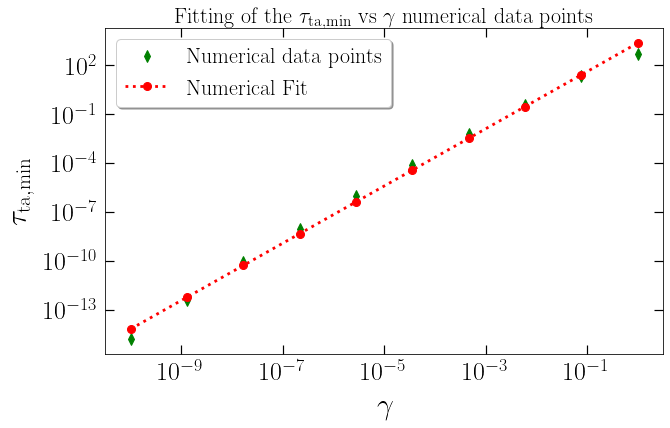

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
x  = gamma_arr
y  = min_tau_arr

plt.loglog(x, y, 'gd',  label = 'data', markersize = 8)

p = np.polyfit(np.log(x), np.log(y), 1)  # F(x) = (x**m)(10**b) with m = slope, b = intercept.
z = np.polyval(p, np.log(x))
plt.loglog(x, np.exp(z), 'ro', ls = ':', label = 'fit', markersize = 8)
print("Slope and intercept of fitting function =", p) 
ax.tick_params(axis='x', pad=6.9)
ax.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax.set_ylabel(r'$ \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax.legend(["Numerical data points", "Numerical Fit"], prop={'size':22}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r'Fitting of the $ \tau_\mathrm{ta, min}$ vs $\gamma$ numerical data points', fontsize = 22 )
plt.savefig("yta_min_vs_gamma.pdf", bbox_inches='tight')
plt.show()


# So, the fitting function is tau_ta_min(gamma) = (10**(7.7504/np.log(10)))  * (gamma**1.7563)  

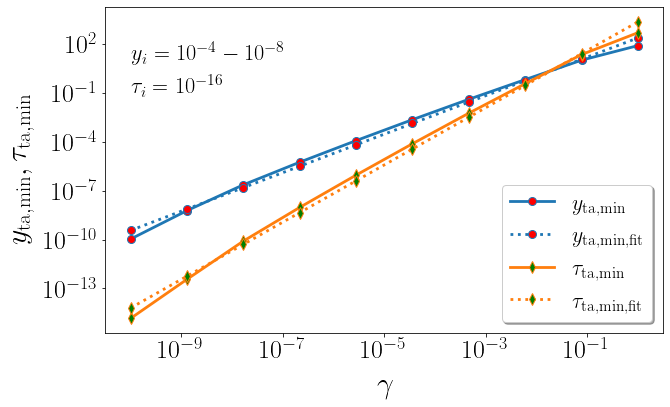

In [7]:
def y_ta_min(variable):
    m = 1.1818
    b = 5.4838/np.log(10)
    return (variable**m) * (10**b)


def tau_ta_min(variable):
    m = 1.7563
    b = 7.7504/np.log(10)
    return (variable**m) * (10**b)


fig, ax = plt.subplots(figsize=(10, 6))
gamma_arr, min_tau_arr, min_y_arr, _ = zip(*min_turnaround_pts)
y_ta_min_arr = np.zeros(len(gamma_arr))
tau_ta_min_arr = np.zeros(len(gamma_arr))

for i, gamma in enumerate(gamma_arr):    
    y_ta_min_arr[i] = y_ta_min(gamma)
    tau_ta_min_arr[i] = tau_ta_min(gamma)

ax.loglog(gamma_arr, min_y_arr, 'C0', marker='o', markersize=8, markerfacecolor='r',ls = '-')
ax.loglog(gamma_arr, y_ta_min_arr, 'C0', marker='o', markersize=8, markerfacecolor='r', ls = ':')
ax.loglog(gamma_arr, min_tau_arr, 'C1', marker='d', markersize=8, markerfacecolor='g', ls = '-')
ax.loglog(gamma_arr, tau_ta_min_arr, 'C1' , marker='d', markersize=8, markerfacecolor='g', ls = ':')

plt.text(1e-10, 10, '$y_i = 10^{-4} - 10^{-8}$', fontsize=22.5)
plt.text(1e-10, 0.1, r'$\tau_i = 10^{-16}$', fontsize=22.5)

ax.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax.legend([r"$y_\mathrm{ta, min}$", r"$y_\mathrm{ta, min,fit}$" , r"$\tau_\mathrm{ta, min}$", r"$\tau_\mathrm{ta, min,fit}$"], prop={'size':22}, loc='lower right', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)

plt.savefig("yta_min_vs_gamma_fit.pdf", bbox_inches='tight')
plt.show()